In [1]:
from cgr.filepaths import filepaths
from cgr.draw import draw_molecule, draw_reaction
from cgr.cheminfo import MorganFingerprinter, tanimoto_similarity
import json
from IPython.display import SVG
from rdkit import Chem
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
from scipy.stats import entropy
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def show_rxn(sma: str):
    display(SVG(draw_reaction(sma)))

In [3]:
krs = filepaths.data / "raw" / "sprhea_240310_v3_mapped_no_subunits.json"
with open(krs, 'r') as f:
    krs = json.load(f)

In [4]:
decarb = {k: v for k,v  in krs.items() if v['min_rule'] == 'rule0024'}
print(len(decarb))

86


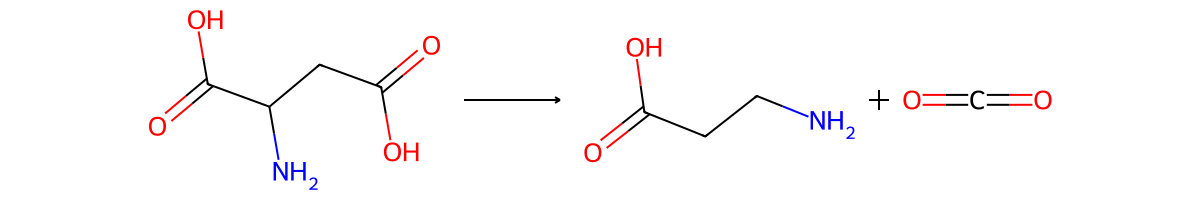

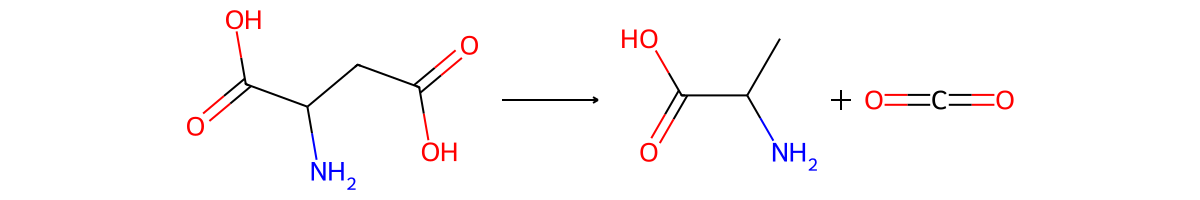

In [5]:
alpha_amino_id = '1162'
beta_amino_id = '17157'

alpha_smarts = decarb[alpha_amino_id]['smarts']
beta_smarts = decarb[beta_amino_id]['smarts']

alpha_smi = alpha_smarts.split('>>')[0]
beta_smi = beta_smarts.split('>>')[0]

alpha_mol = Chem.MolFromSmiles(alpha_smi)
beta_mol = Chem.MolFromSmiles(beta_smi)

show_rxn(alpha_smarts)
show_rxn(beta_smarts)

In [6]:
radius = 3
length = 2**11
mfper = MorganFingerprinter(radius=radius, length=length)

In [7]:
alpha_mfp = mfper.fingerprint(alpha_mol)
beta_mfp = mfper.fingerprint(beta_mol)
tanimoto_similarity(alpha_mfp, beta_mfp)

np.float64(1.0)

In [8]:
alpha_rc = decarb[alpha_amino_id]['reaction_center'][0]
beta_rc = decarb[beta_amino_id]['reaction_center'][0]

alpha_mfp_w_loc = mfper.fingerprint(alpha_mol, reaction_center=alpha_rc)
beta_mfp_w_loc = mfper.fingerprint(beta_mol, reaction_center=beta_rc)
tanimoto_similarity(alpha_mfp_w_loc, beta_mfp_w_loc)

np.float64(0.2777777777777778)

In [9]:
print(f"normal: {float((alpha_mfp.sum() / length) * 100):2f}% density")
print(f"w/ loc: {float((alpha_mfp_w_loc.sum() / length) * 100):2f}% density")

normal: 0.878906% density
w/ loc: 1.123047% density


In [10]:
radius = 2
length = 2**11
mfper = MorganFingerprinter(radius=radius, length=length)
rc_dist_ub = 1

M = [] # Trad morgan
L = [] # w/ location info
R = [] # w/ loc info and rooted at peri-rc substructure
for key, rxn in decarb.items():
        rc = rxn['reaction_center'][0]
        smiles = rxn['smarts'].split('>>')[0]
        mol = Chem.MolFromSmiles(smiles)
        M.append(mfper.fingerprint(mol))
        L.append(mfper.fingerprint(mol, reaction_center=rc))
        R.append(mfper.fingerprint(mol, reaction_center=rc, rc_dist_ub=rc_dist_ub))

M = np.vstack(M)
L = np.vstack(L)
R = np.vstack(R)

tmp = []
for mat in [M, L, R]:
    c = mat.sum(axis=1) # Cardinality
    S = np.matmul(mat, mat.T) # Straight dot product
    tmp.append(S / (c.reshape(1, -1) + c.reshape(-1, 1) - S)) # Tanimoto similarity
    # tmp.append(S)

Sm, Sl, Sr = tmp

In [45]:
kopts = list(decarb.keys())
sim_mats = {
    'traditional': Sm,
    'location': Sl,
    'location_rooted': Sr
}
stopts = list(sim_mats.keys())

@interact
def rank_by_one(
    query = widgets.Dropdown(value=kopts[0], options=kopts),
    sim_type = widgets.Dropdown(value=stopts[0], options=stopts),
    topk: int = 10
):    

    idx = kopts.index(query)
    sim_row = sim_mats[sim_type][idx, :]
    srt_sim_key = sorted(zip(sim_row, kopts), key=lambda x : x[0], reverse=True)

    for i, (sim, k) in enumerate(srt_sim_key):
        if i == 0:
            print("Query")
        else:
            print(f"Other ID: {k}")
            print(f"Similarity score: {sim}")
        
        rxn = decarb[k]
        rc = rxn['reaction_center'][0]
        smiles = rxn['smarts'].split('>>')[0]
        display(SVG(draw_molecule(smiles, hilite_atoms=rc, size=(400, 250))))

        if i == 0:
            print('-' * 50)

        if i > topk:
            break

interactive(children=(Dropdown(description='query', options=('14', '55', '121', '734', '1067', '1162', '1565',…

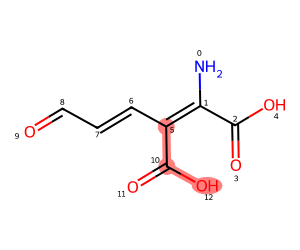

In [12]:
rid = '121'
rc_dist_ub = 1
mfper = MorganFingerprinter(radius=2, length=2**11, allocate_ao=True)
substrate_smiles = decarb[rid]['smarts'].split('>>')[0]
substrate_mol = Chem.MolFromSmiles(substrate_smiles)
rc = decarb[rid]['reaction_center'][0]
rmfp = mfper.fingerprint(substrate_mol, rc, rc_dist_ub=rc_dist_ub)
display(SVG(draw_molecule(substrate_smiles, size=(300, 250), hilite_atoms=rc, draw_options={'addAtomIndices': True})))

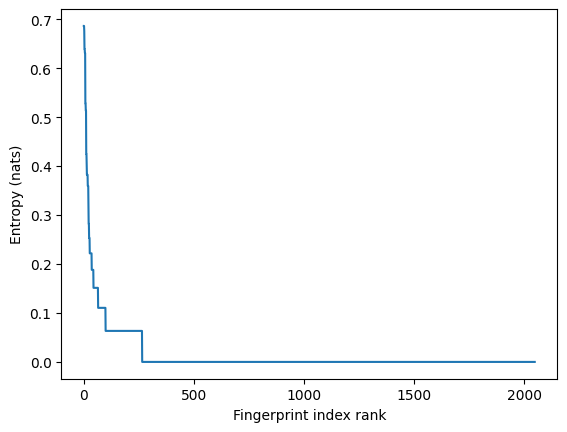

In [13]:
radius = 2
length = 2**11
mfper = MorganFingerprinter(radius=radius, length=length, allocate_ao=True)
rc_dist_ub = 1

embeds = []
bims = [] # BitInfoMaps {bit_idx: ((central atom idx, radius))}
mols = []
for key, rxn in decarb.items():
        rc = rxn['reaction_center'][0]
        smiles = rxn['smarts'].split('>>')[0]
        mol = Chem.MolFromSmiles(smiles)

        embeds.append(mfper.fingerprint(mol, reaction_center=rc, rc_dist_ub=rc_dist_ub))
        bims.append(mfper.bit_info_map)
        mols.append(mol)

embeds = np.vstack(embeds)

p1 = embeds.sum(axis=0) / embeds.shape[0]
probas = np.vstack((p1, (1 - p1)))
elt_entropy = entropy(pk=probas, axis=0)
fp_idx, elt_entropy = zip(*sorted(zip(np.arange(len(elt_entropy)), elt_entropy), key=lambda x : x[1], reverse=True))
x = np.arange(len(elt_entropy))

fig, ax = plt.subplots()
ax.plot(x, elt_entropy)
ax.set_ylabel("Entropy (nats)")
ax.set_xlabel("Fingerprint index rank")
plt.show()

In [14]:
fp_idx[:10]

(np.int64(1224),
 np.int64(1695),
 np.int64(1503),
 np.int64(1447),
 np.int64(1453),
 np.int64(269),
 np.int64(1711),
 np.int64(652),
 np.int64(1704),
 np.int64(1407))

In [15]:
organic_elements = {
    0: '*',
    1: 'H',    # Hydrogen
    6: 'C',    # Carbon
    7: 'N',    # Nitrogen
    8: 'O',    # Oxygen
    9: 'F',    # Fluorine
    16: 'S',   # Sulfur
    17: 'Cl',  # Chlorine
    35: 'Br',  # Bromine
    53: 'I',   # Iodine
    15: 'P',   # Phosphorus
}

def get_subsmiles(molecule: Chem.Mol, aidx: int, radius: int):
    if radius == 0:
        atomic_num = molecule.GetAtomWithIdx(aidx).GetAtomicNum()
        return organic_elements[atomic_num]

    env = Chem.FindAtomEnvironmentOfRadiusN(
        mol=molecule,
        radius=radius,
        rootedAtAtom=aidx
    )

    submol = Chem.PathToSubmol(
        mol=molecule,
        path=env    
    )

    return Chem.MolToSmiles(submol)

fpidx_2_unique_smiles = defaultdict(set)

for idx in fp_idx:
    for bim, mol in zip(bims, mols):
        roots = bim.get(idx, tuple())
        for aidx, radius in roots:
            subsmiles = get_subsmiles(mol, aidx, radius)
            fpidx_2_unique_smiles[idx].add(subsmiles)

In [16]:
fpidx_2_unique_smiles

defaultdict(set,
            {np.int64(1224): {'C'},
             np.int64(1695): {'CC(=O)O', 'CO'},
             np.int64(1503): {'C'},
             np.int64(1447): {'N'},
             np.int64(1453): {'CN'},
             np.int64(269): {'CC(C)N'},
             np.int64(1711): {'CC(N)C(=O)O'},
             np.int64(652): {'C'},
             np.int64(1704): {'CC(=O)O'},
             np.int64(1407): {'C=O'},
             np.int64(1964): {'O'},
             np.int64(422): {'C', 'cc(C)c(C(=O)O)c(c)O'},
             np.int64(1155): {'C'},
             np.int64(1531): {'CC(=O)O'},
             np.int64(252): {'CCC(N)C(=O)O'},
             np.int64(702): {'CC(C)=O'},
             np.int64(1042): {'CC(=O)C(=O)O'},
             np.int64(1059): {'CCC'},
             np.int64(610): {'C'},
             np.int64(815): {'C'},
             np.int64(1246): {'cC(=O)O'},
             np.int64(2005): {'cCC(N)C(=O)O', 'ccc([nH]c)C(=O)O'},
             np.int64(14): {'CCc', 'cCC'},
             np.int64(2

In [17]:
n_collisions = 0
for k, v in fpidx_2_unique_smiles.items():
    if len(v) > 1:
        n_collisions += 1


print(f"Collision rate: {n_collisions / len(fpidx_2_unique_smiles)}")

Collision rate: 0.1111111111111111


In [18]:
sparsities = embeds.sum(axis=1)
print(f"Sparsity: {sparsities.mean():.2f} +/- {sparsities.std():.2f}")

Sparsity: 14.71 +/- 1.17


In [19]:
mols_w_fpids = defaultdict(list)
egs = [0 for i in range(len(fp_idx))]
for idx in fp_idx:
    for bim, mol in zip(bims, mols):
        if idx in bim:
            mols_w_fpids[idx].append((bim[idx], mol))

Entropy = 0.686371452146747 nats


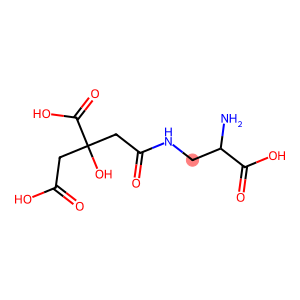

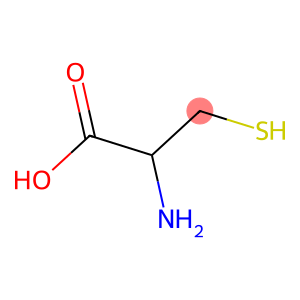

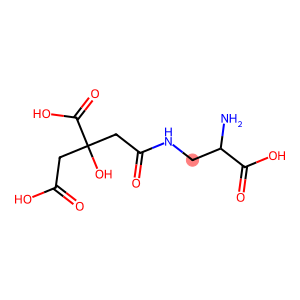

--------------------------------------------------
Entropy = 0.686371452146747 nats


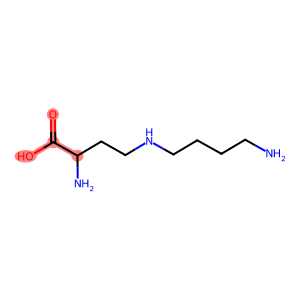

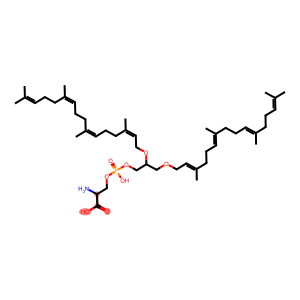

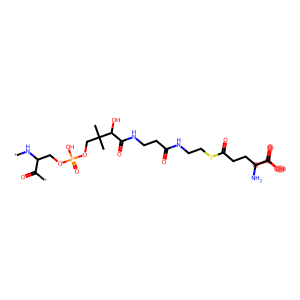

--------------------------------------------------
Entropy = 0.6757392797294369 nats


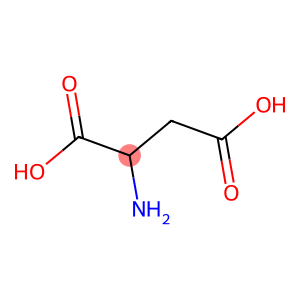

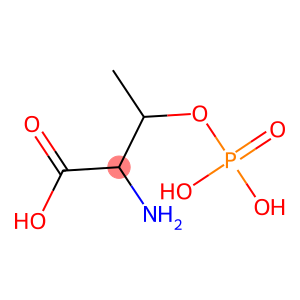

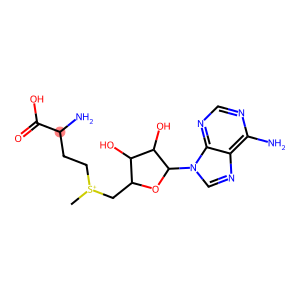

--------------------------------------------------
Entropy = 0.6391670481584251 nats


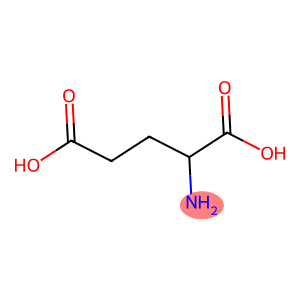

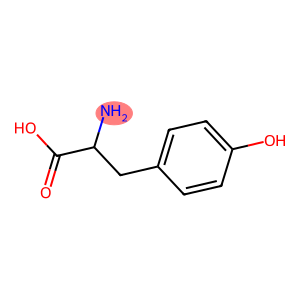

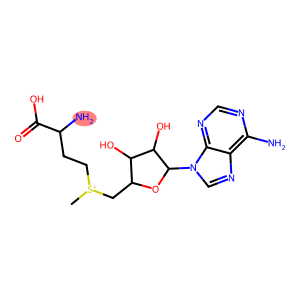

--------------------------------------------------
Entropy = 0.6391670481584251 nats


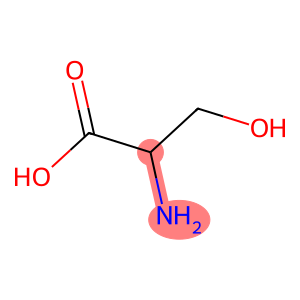

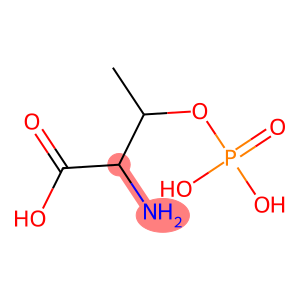

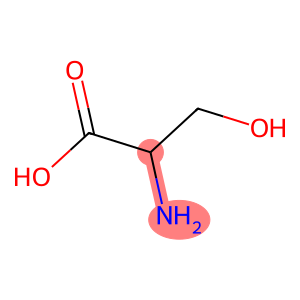

--------------------------------------------------
Entropy = 0.6310051928046935 nats


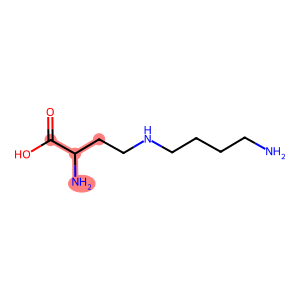

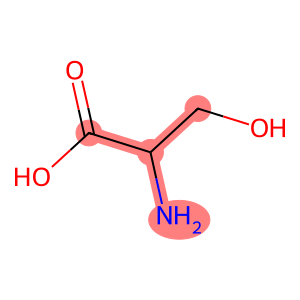

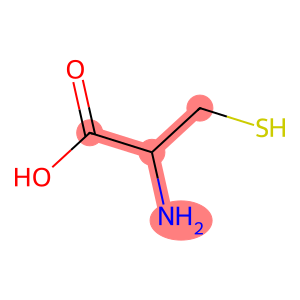

--------------------------------------------------
Entropy = 0.6310051928046935 nats


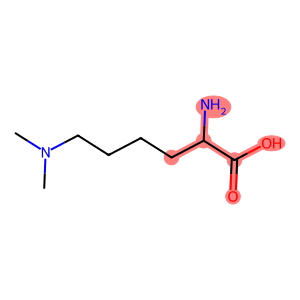

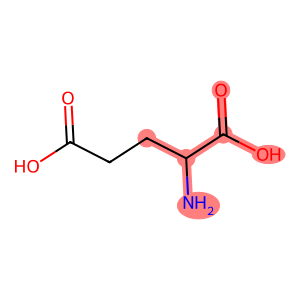

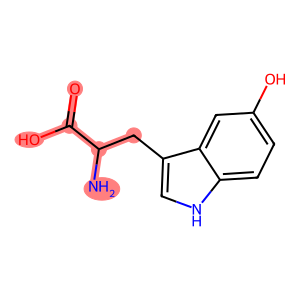

--------------------------------------------------
Entropy = 0.5280828066795881 nats


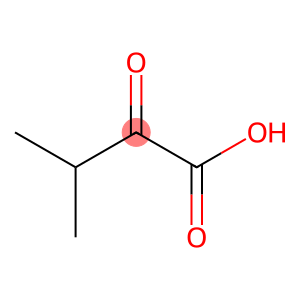

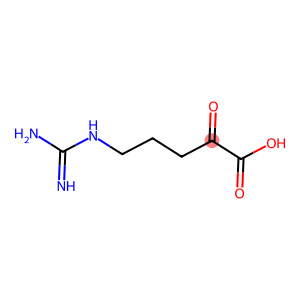

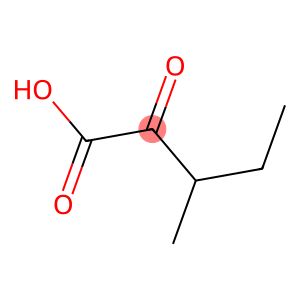

--------------------------------------------------
Entropy = 0.5280828066795881 nats


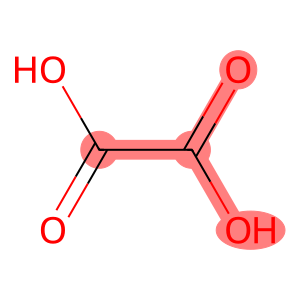

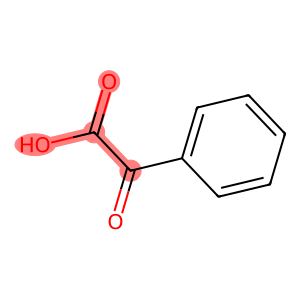

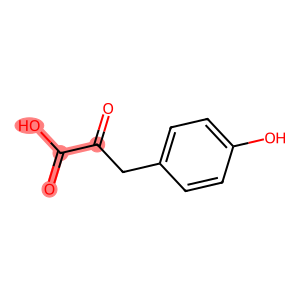

--------------------------------------------------
Entropy = 0.5130308358569238 nats


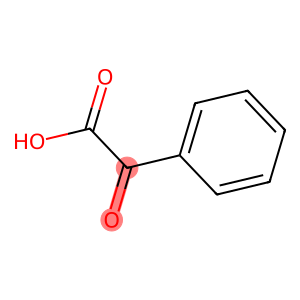

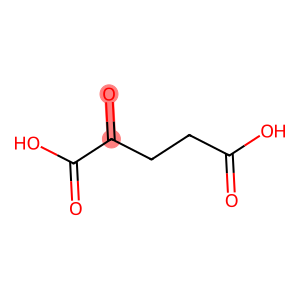

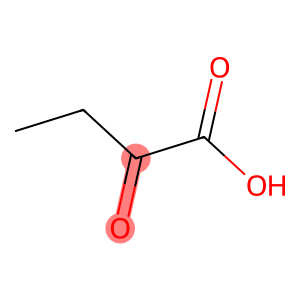

--------------------------------------------------


In [47]:
rng = np.random.default_rng(seed=1234) # TODO seed=1234, resampling same integer for first hash / substruct
n_egs = 3
topk = 10
for (idx, ent) in zip(fp_idx[:topk], elt_entropy[:topk]):
    egs = rng.integers(low=0, high=len(mols_w_fpids[idx]) - 1, size=(n_egs, ))
    print(f"Entropy = {ent} nats")
    for eg in egs:
        sub_atom_idxs = set()
        roots, mol = mols_w_fpids[idx][eg]
        aidx, r = roots[0]

        if r == 0:
            sub_atom_idxs.add(aidx)
        else:
            env = Chem.FindAtomEnvironmentOfRadiusN(
                mol=mol,
                radius=r,
                rootedAtAtom=aidx
            )
            for bidx in env:
                bond = mol.GetBondWithIdx(bidx)
                sub_atom_idxs.add(bond.GetBeginAtomIdx())
                sub_atom_idxs.add(bond.GetEndAtomIdx())

        display(SVG(draw_molecule(mol, size=(300, 300), hilite_atoms=tuple(sub_atom_idxs))))
    print('-' * 50)
    

In [77]:
# kopts = list(decarb.keys())

# @interact
# def compare_two(key1 = widgets.Dropdown(value=kopts[0], options=kopts), key2 = widgets.Dropdown(value=kopts[0], options=kopts), radius: int = 3, length: int = 2**11):    
#     mfper = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=length)
#     svgs = []
#     mfps = []
#     mfps_w_loc = []
#     for key in [key1, key2]:
#         rxn = decarb[key]
#         rc = rxn['reaction_center'][0]
#         smiles = rxn['smarts'].split('>>')[0]
#         svgs.append(widgets.HTML(draw_molecule(smiles, hilite_atoms=rc, size=(500, 300))))
        
        
#         mol = Chem.MolFromSmiles(smiles)
#         custom_feats = featurize_mol(mol, rc)
#         mfps.append(mfper.GetFingerprintAsNumPy(mol))
#         mfps_w_loc.append(mfper.GetFingerprintAsNumPy(mol, customAtomInvariants=custom_feats))
        
#     ts = tanimoto_similarity(*mfps)
#     ts_w_loc = tanimoto_similarity(*mfps_w_loc)

#     print(f"standard: {ts}")
#     print(f"w/ loc: {ts_w_loc}")

#     display(widgets.HBox(svgs))